In [1]:
from root import *

## Precipitations VS Duration

#### En principio se buscara visualizar la distribucion de la duración de los viajes de acuerdo a las diferentes medidas de precipitaciones

In [2]:
#Descarto las rows que no me brindan datos acerca de las precipitaciones
dfPrecipitations = dfWeather[['date', 'zip_code', 'precipitation_inches', 'events']]
dfPrecipitations.precipitation_inches = dfPrecipitations.precipitation_inches.convert_objects(convert_numeric=True)
#Los no numericos quedan como NaN y los limpio
dfPrecipitations = dfPrecipitations[dfPrecipitations.precipitation_inches.notnull()]
print 'Se limpiaron %d registros' % (len(dfWeather) - len(dfPrecipitations))

Se limpiaron 144 registros


/home/ralvarado/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
/home/ralvarado/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [3]:
dfPrecipitations.columns

Index([u'date', u'zip_code', u'precipitation_inches', u'events'], dtype='object')

In [4]:
dfTrip_N_Precipitations = dfTrip[['duration', 'start_date', 'start_station_id']]
dfTrip_N_Precipitations.rename(columns={'start_station_id':'id'}, inplace=True)
dfTrip_N_Precipitations = dfTrip_N_Precipitations.merge(dfStation[['id', 'city']], on=['id'])

#Recorto los viajes de menos de 2 minutos y mayores a 6 horas
dfTrip_N_Precipitations = dfTrip_N_Precipitations[(60*2 <= dfTrip_N_Precipitations.duration) & (dfTrip_N_Precipitations.duration <= 3600*6)]
dfTrip_N_Precipitations.sort_values(by='duration')

################### Realizo la conversión para hacer merge de los datos ###############################
dfTrip_N_Precipitations['zip_code'] = dfTrip_N_Precipitations.apply(cityNameToZipCode, axis=1)
dfTrip_N_Precipitations.start_date = pd.to_datetime(dfTrip_N_Precipitations.start_date.dt.date)

dfTrip_N_Precipitations.rename(columns={'start_date':'date'}, inplace=True)
dfTrip_N_Precipitations = dfTrip_N_Precipitations[['duration', 'date', 'city', 'zip_code']]
# Convierto a int64 para poder hacer el merge
dfTrip_N_Precipitations.zip_code = pd.to_numeric(dfTrip_N_Precipitations.zip_code)
dfTrip_N_Precipitations = dfTrip_N_Precipitations.merge(dfPrecipitations, on=['date', 'zip_code'])

dfTrip_N_Precipitations.sort_values(by='date', inplace=True)
dfTrip_N_Precipitations.head()

/home/ralvarado/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,duration,date,city,zip_code,precipitation_inches,events
0,168,2013-08-29,San Francisco,94107,0.0,NaN
483,1107,2013-08-29,San Francisco,94107,0.0,NaN
484,1210,2013-08-29,San Francisco,94107,0.0,NaN
485,1244,2013-08-29,San Francisco,94107,0.0,NaN
486,1251,2013-08-29,San Francisco,94107,0.0,NaN


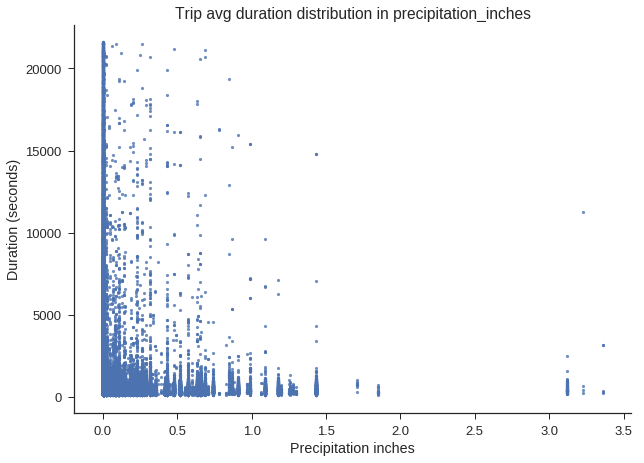

In [5]:
sns.set(font_scale=1.30)
sns.set_style("ticks")

graf = sns.lmplot(x='precipitation_inches', y='duration',
           data=dfTrip_N_Precipitations,
           fit_reg=False,
           scatter_kws={"s":10}
          )
graf.fig.set_size_inches(11, 7)
           
plt.title('Trip avg duration distribution in precipitation_inches')
plt.xlabel('Precipitation inches')
plt.ylabel('Duration (seconds)')
plt.show()

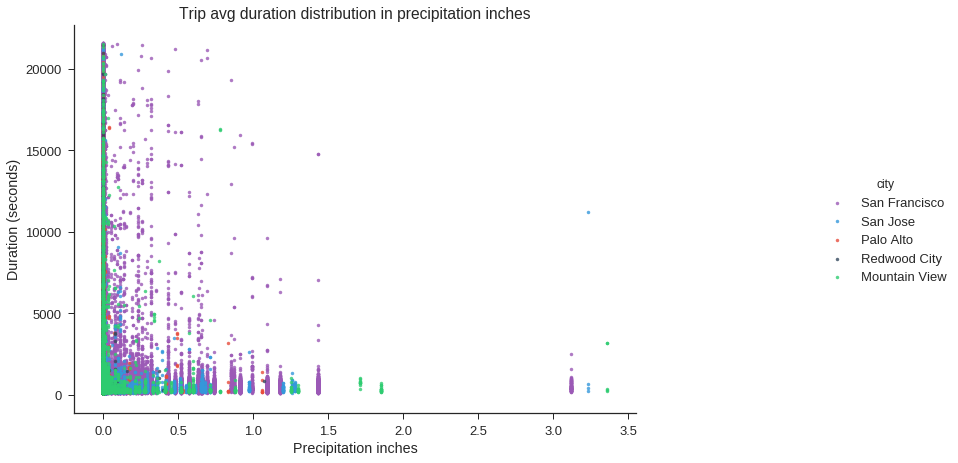

In [6]:
sns.set(font_scale=1.30)
sns.set_style("ticks")
flatui = ["#9b59b6", "#3498db","#e74c3c", "#34495e", "#2ecc71"]
graf = sns.lmplot(x='precipitation_inches', y='duration',
           data=dfTrip_N_Precipitations,
           fit_reg=False,
           hue = "city",
           palette = flatui,
           scatter_kws={"s":12}
          )
graf.fig.set_size_inches(16, 7)
           
plt.title('Trip avg duration distribution in precipitation inches')
plt.xlabel('Precipitation inches')
plt.ylabel('Duration (seconds)')
plt.show()

#### Se puede observar que a medida que las precipitaciones son mas copiosas, los viajes comienzan a descender en duracion y también en cantidad.
#### Por otra parte se puede ver que los viajes iniciados en Mountain View son en su grán mayoría en dias en donde las precipitaciones estan en 0. Si bien esta tendencia se puede ver en todas las ciudades, la diferencia en Mountain View es mucho mas marcada.
#### Algo raro que también se puede observar es que aparecen algunos viajes a partir de los 3 inches.

In [7]:

print 'Viajes en los que el nivel de precipitaciones es menor a 2 inches es: %d' % len(dfTrip_N_Precipitations[dfTrip_N_Precipitations.precipitation_inches < 2])
print 'Viajes en los que el nivel de precipitaciones es mayor a 3 inches es: %d' % len(dfTrip_N_Precipitations[dfTrip_N_Precipitations.precipitation_inches > 3])

Viajes en los que el nivel de precipitaciones es menor a 2 inches es: 597733
Viajes en los que el nivel de precipitaciones es mayor a 3 inches es: 102


#### Si bien la cantidad de viajes, cuando las precipitaciones son de mas de 3 inches, es muy baja, se verifica ver por qué razón podría la gente tomar bicis en este nivel y ninguna cuando es de 1 a 2 (En este caso la cantidad es 0)

In [8]:
dfTrip_N_Precipitations[dfTrip_N_Precipitations.precipitation_inches > 3].events.unique()

array(['Rain'], dtype=object)

#### Se puede ver que los registros en los que el valor 'Precipitation inches' es mayor a 3 habia lluvia, al parecer muy copiosa, pero no tormenta. Visto esto se procede a realizar el mismo gráfico anterior tomando en cuenta los eventos meteorológicos.

In [9]:
dfTrip_N_PrecipNormalizedEvents = dfTrip_N_Precipitations[dfTrip_N_Precipitations.events.notnull()]
dfTrip_N_PrecipNormalizedEvents.events = dfTrip_N_PrecipNormalizedEvents.events.apply(lambda event: event.capitalize())
dfTrip_N_PrecipNormalizedEvents

,duration,date,city,zip_code,precipitation_inches,events
587326,806,2013-09-03,Mountain View,94041,1.71,Rain
587325,1017,2013-09-03,Mountain View,94041,1.71,Rain
587324,721,2013-09-03,Mountain View,94041,1.71,Rain
587327,717,2013-09-03,Mountain View,94041,1.71,Rain
587328,943,2013-09-03,Mountain View,94041,1.71,Rain
587330,801,2013-09-03,Mountain View,94041,1.71,Rain
587329,340,2013-09-03,Mountain View,94041,1.71,Rain
587333,875,2013-09-03,Mountain View,94041,1.71,Rain
587332,733,2013-09-03,Mountain View,94041,1.71,Rain
587331,634,2013-09-03,Mountain View,94041,1.71,Rain


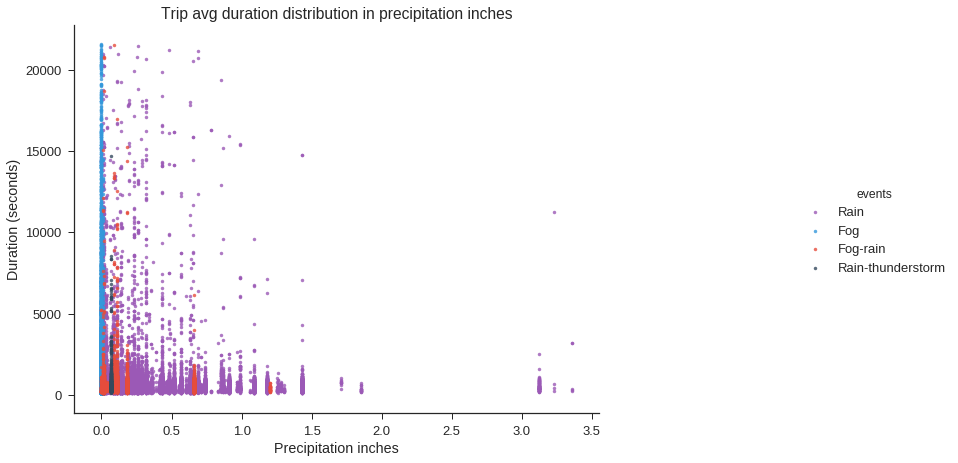

In [10]:
sns.set(font_scale=1.30)
sns.set_style("ticks")
flatui = ["#9b59b6", "#3498db","#e74c3c", "#34495e", "#2ecc71"]
graf = sns.lmplot(x='precipitation_inches', y='duration',
           data=dfTrip_N_PrecipNormalizedEvents,
           fit_reg=False,
           hue = "events",
           palette = flatui,
           scatter_kws={"s":12}
          )
graf.fig.set_size_inches(16, 7)
           
plt.title('Trip avg duration distribution in precipitation inches')
plt.xlabel('Precipitation inches')
plt.ylabel('Duration (seconds)')
plt.show()

#### Se puede observar que la gente solo alquila en dias de tormenta eléctrica cuando el nivel de precipitación es muy cercano a 0.
#### Se realiza un plot un poco mas adecuado para mostrar esto ya que la duración no nos está dando muchos datos relevantes.

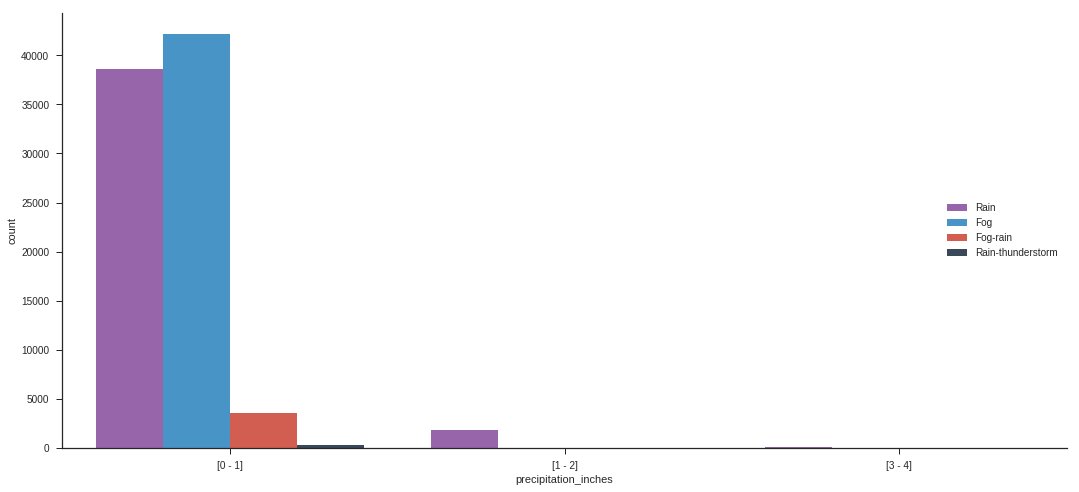

In [15]:
dfTrip_N_PrecipNormalizedEvents.precipitation_inches = dfTrip_N_PrecipNormalizedEvents.precipitation_inches.apply(lambda preInch: int(preInch))
sns.set(style="ticks")
countPlot = sns.countplot(x="precipitation_inches", hue="events", data=dfTrip_N_PrecipNormalizedEvents, palette = flatui)
sns.despine()
countPlot.figure.set_size_inches(18, 8)
countPlot.set_xticklabels(['[0 - 1]', '[1 - 2]', '[3 - 4]'])
countPlot.legend(loc='right')

plt.show()